# ATLAS Test Beam Data

Python script for analysis of ATLAS test beam data. 

The program reads an ASCII (i.e. text) data file, containting a large number of events, where a charged particle (electron or pion) passed through a slice of the ATLAS detector. Each passage is recorded by different detectors (essentially three independent ones!), boiling down to eleven numbers (some more relevant than others). The exercise is to separate electron and pion events based on these numbers, and in turn use this information to measure the interaction (i.e. detector performance) of pions and electrons seperately.

NOTE 1: In this exercise, don't consider (at least at first) the details, but just rely on the advice from particle physicist, that in these detectors, electrons tend to give a higher signal (i.e. values) than pions do, and that none of the particle types are very rare.

NOTE 2: Though the data is from particle physics, it could in principle have been from ANY other source, and the eleven numbers could for example have been indicators of cancer, key numbers for investors, or index numbers for identifying potential costumors. Thus the advice from above could be from and old doctor, economist, or marketing consultant.

NOTE 3: This is real data, and while it has been prepared somewhat, it might contain surprises and does not necessarily follow known PDFs.

For more information on ATLAS test beam: http://www.nbi.dk/~petersen/Teaching/Stat2025/TestBeam/TestBeamDataAnalysis.html.

***

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)


In [26]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Set parameters of the program:

In [27]:
# Write extensive output
verbose = True
N_verbose = 20

Open file, `DataSet_AtlasPid_ElectronPion_2GeV.txt`, and read in all the data:

In [28]:
data = np.loadtxt('DataSet_AtlasPid_ElectronPion_2GeV.txt', skiprows=1, unpack=True)
Cher, nLT, nHT, EM0, EM1, EM2, EM3, Had0, Had1, Had2, Muon = data
Cher.shape

# It is always very "healthy" to inspect the data visually/manually, just to get a quick feel for it.
if (verbose) :
    for i in range (N_verbose) :
        print(f"Cher: {Cher[i]:6.1f}    nLT, nHT: {int(nLT[i]):2d}, {int(nHT[i]):2d}    EM: {EM0[i]:5.2f} {EM1[i]:5.2f} {EM2[i]:5.2f} {EM3[i]:5.2f}   Had: {Had0[i]:5.2f} {Had1[i]:5.2f} {Had2[i]:5.2f}    Muon: {Muon[i]:5.1f}")

Cher:  634.0    nLT, nHT: 32,  8    EM:  0.12  0.47  0.87 -0.04   Had:  0.00  0.00  0.00    Muon: 417.0
Cher:  816.0    nLT, nHT: 42, 12    EM:  0.05  0.87  0.77 -0.01   Had:  0.00  0.00  0.00    Muon: 388.0
Cher:  943.0    nLT, nHT: 46,  8    EM:  0.19  0.53  0.96  0.01   Had:  0.00  0.00  0.00    Muon: 377.0
Cher:  907.0    nLT, nHT: 33,  3    EM:  0.20  0.74  0.72  0.02   Had:  0.00  0.00  0.00    Muon: 372.0
Cher:  775.0    nLT, nHT: 35,  4    EM: -0.01  0.82  0.57  0.02   Had:  0.00  0.00  0.00    Muon: 392.0
Cher:  773.0    nLT, nHT: 39,  9    EM:  0.10  1.24  0.27 -0.03   Had:  0.00  0.00  0.00    Muon: 398.0
Cher:  782.0    nLT, nHT: 30,  7    EM:  0.35  0.89  0.60 -0.04   Had:  0.00  0.00  0.00    Muon: 369.0
Cher:  700.0    nLT, nHT: 39,  9    EM:  0.03  1.14  0.60  0.02   Had:  0.00  0.03  0.76    Muon: 408.0
Cher:  542.0    nLT, nHT: 42,  1    EM: -0.03 -0.01  0.13 -0.05   Had:  0.00  0.00  0.00    Muon: 412.0
Cher:  752.0    nLT, nHT: 40,  7    EM:  0.09  0.66  0.57  0.10 

## Your analysis:

Through plotting and making selections in one/several variable(s) seeing the impact (e.g. how many events remain) in others, work out what this sample consists of. 

In [29]:
# Calculate ROC curve from two histograms (hist1 is signal, hist2 is background):
def calc_ROC(hist1, hist2) :

    # First we extract the entries (y values) and the edges of the histograms:
    # Note how the "_" is simply used for the rest of what e.g. "hist1" returns (not really of our interest)
    y_sig, x_sig_edges, _ = hist1 
    y_bkg, x_bkg_edges, _ = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges) :
        
        # Extract the center positions (x values) of the bins (both signal or background works - equal binning)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # Calculate the integral (sum) of the signal and background:
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # Initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR):
        TPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FPR = np.zeros_like(y_sig) # False positive rate ()
        
        # Loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin:
        for i, x in enumerate(x_centers): 
            
            # The cut mask
            cut = (x_centers < x)
            
            # True positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            TPR[i] = TP / (TP + FN)                    # True positive rate
            
            # True negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (FP + TN)                     # False positive rate            
            
        return FPR, TPR
    
    else:
        AssertionError("Signal and Background histograms have different bins and/or ranges")

In [30]:

# mask = Had0 + Had1 + Had2 < 0.01

# cher_cut = Cher[mask]

# print(len(Cher), len(cher_cut))


cher_cut = Cher[Cher < 600]


trt_ratio = nHT/nLT



An example plot could be to see if there are any clear types difference between the entries in the data, and if this gives rise to a way of selecting 

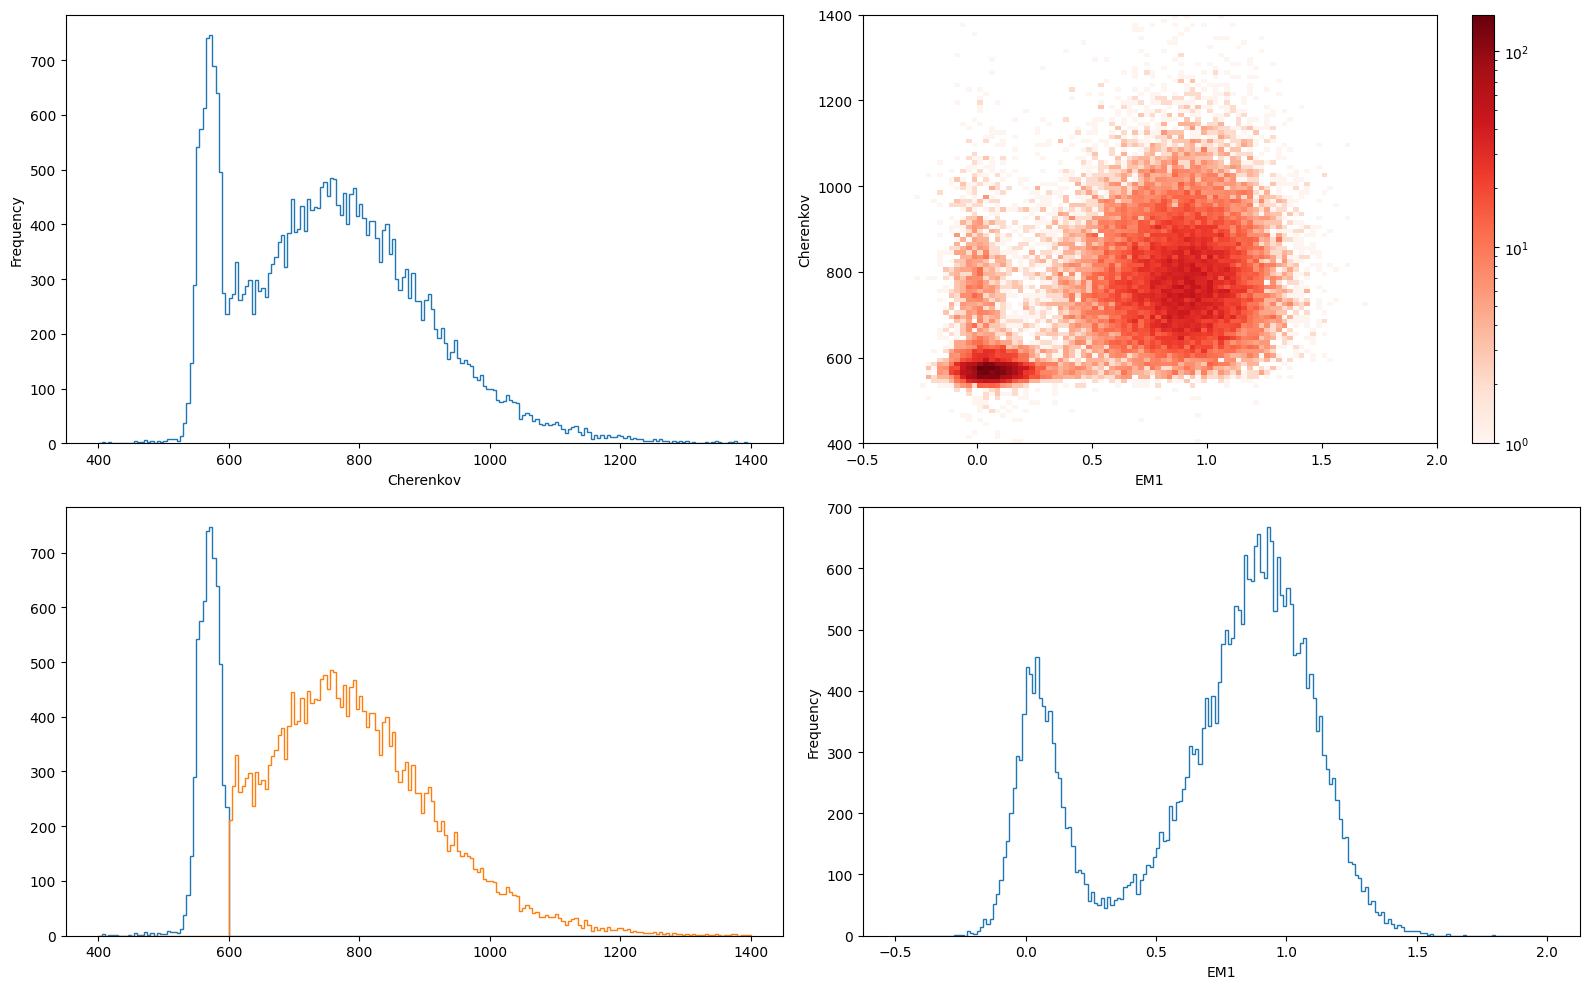

In [31]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))

background = ax[0,0].hist(Cher, bins=200, range=(400, 1400), histtype='step', label='Cherenkov')
ax[0,0].set(xlabel="Cherenkov", ylabel="Frequency")

ax[1,1].hist(EM1,  bins=200, range=(-0.5, 2.0), histtype='step', label='EM1')
ax[1,1].set(xlabel="EM1", ylabel="Frequency")

h = ax[0,1].hist2d(EM1,  Cher, bins=(100, 100), range=((-0.5, 2.0), (400, 1400)), norm=mpl.colors.LogNorm(), cmap="Reds")
plt.colorbar(h[3], ax=ax[0, 1])                    # z-scale on the right of the figure
ax[0,1].set(xlabel="EM1", ylabel="Cherenkov")

# You can add your own fourth plot:
pions = ax[1,0].hist(cher_cut, bins=200, range=(400, 1400), histtype='step', label='Cherenkov')
ax[1,0].hist(Cher[Cher > 600], bins=200, range=(400, 1400), histtype='step', label='Cherenkov')

# fig.delaxes(ax[1,0])
fig.tight_layout()

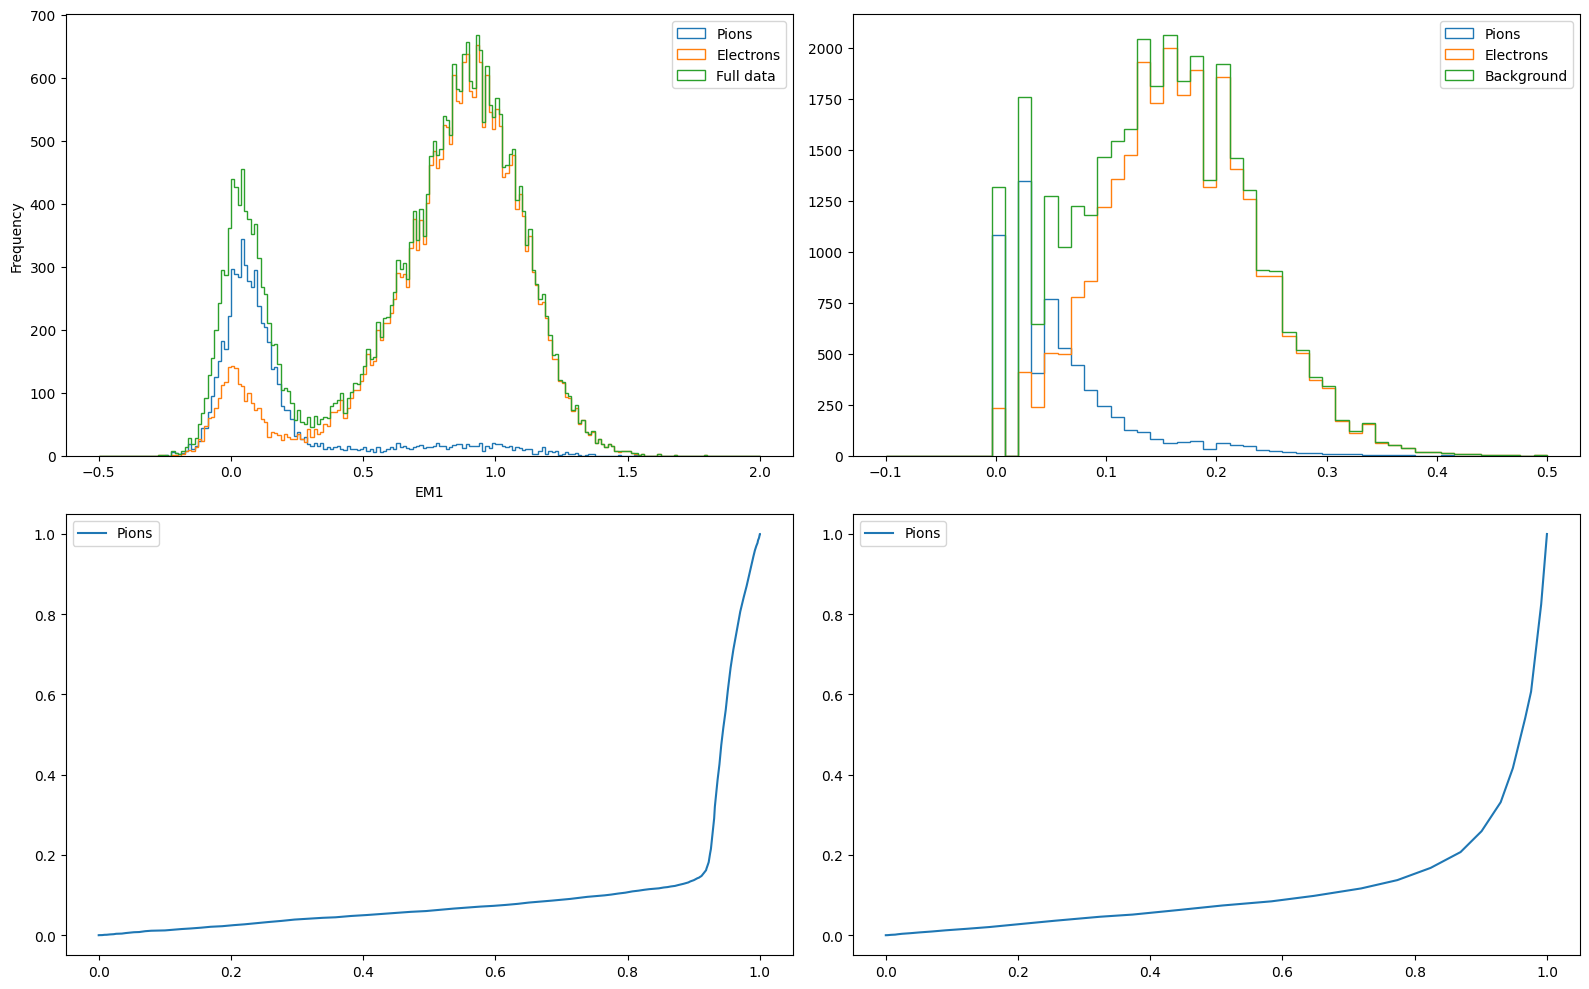

In [32]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))

mask = Cher < 600

pions = ax[0,0].hist(EM1[mask],  bins=200, range=(-0.5, 2.0), histtype='step', label='Pions')
electron = ax[0,0].hist(EM1[~mask],  bins=200, range=(-0.5, 2.0), histtype='step', label='Electrons')
background = ax[0,0].hist(EM1,  bins=200, range=(-0.5, 2.0), histtype='step', label='Full data')
ax[0,0].set(xlabel="EM1", ylabel="Frequency")
ax[0,0].legend()

fpr_pion, tpr_pion = calc_ROC(pions, electron)

ax[1,0].plot(fpr_pion, tpr_pion, '-', label = "Pions")
ax[1,0].legend()

pions = ax[0,1].hist(trt_ratio[mask], bins = 50, range = (-0.1, 0.5), histtype = "step", label = "Pions")
electron = ax[0,1].hist(trt_ratio[~mask], bins = 50, range = (-0.1, 0.5), histtype = "step", label = "Electrons")
background = ax[0,1].hist(trt_ratio, bins = 50, range = (-0.1, 0.5), histtype = "step", label = "Background")
ax[0,1].legend()

fpr_pion, tpr_pion = calc_ROC(pions, electron)

ax[1,1].plot(fpr_pion, tpr_pion, '-', label = "Pions")
ax[1,1].legend()

fig.tight_layout()

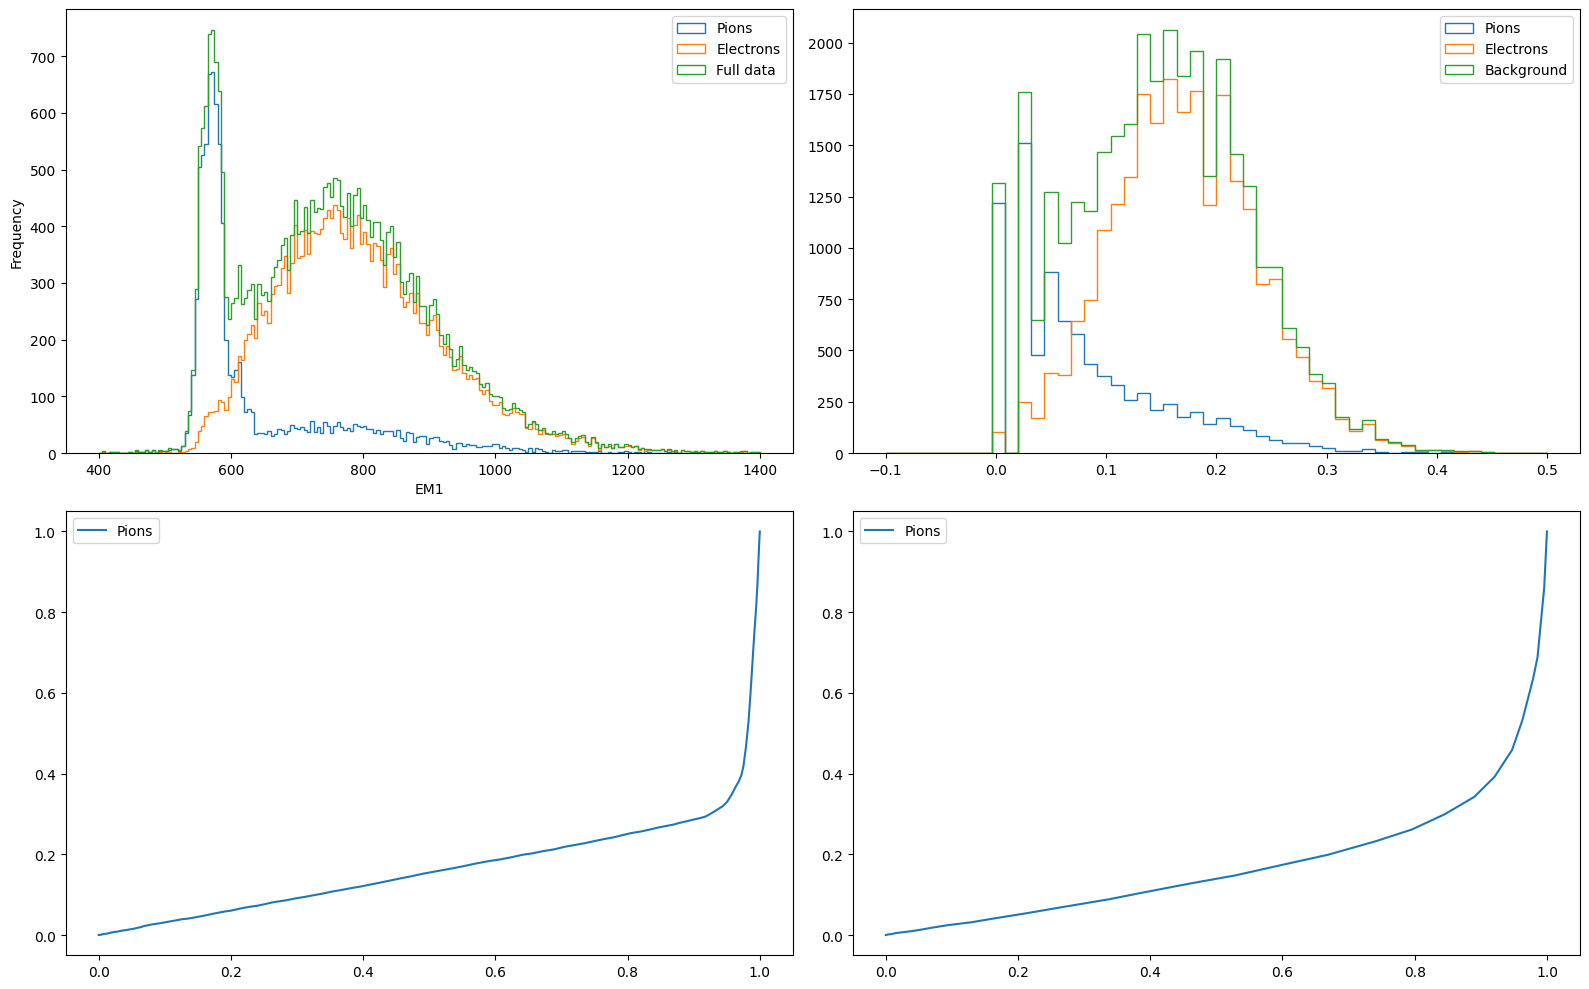

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))

mask = EM1 < 0.5

pions = ax[0,0].hist(Cher[mask],  bins=200, range=(400, 1400), histtype='step', label='Pions')
electron = ax[0,0].hist(Cher[~mask],  bins=200, range=(400, 1400), histtype='step', label='Electrons')
background = ax[0,0].hist(Cher,  bins=200, range=(400, 1400), histtype='step', label='Full data')
ax[0,0].set(xlabel="EM1", ylabel="Frequency")
ax[0,0].legend()

fpr_pion, tpr_pion = calc_ROC(pions, electron)

ax[1,0].plot(fpr_pion, tpr_pion, '-', label = "Pions")
ax[1,0].legend()

pions = ax[0,1].hist(trt_ratio[mask], bins = 50, range = (-0.1, 0.5), histtype = "step", label = "Pions")
electron = ax[0,1].hist(trt_ratio[~mask], bins = 50, range = (-0.1, 0.5), histtype = "step", label = "Electrons")
background = ax[0,1].hist(trt_ratio, bins = 50, range = (-0.1, 0.5), histtype = "step", label = "Background")
ax[0,1].legend()

fpr_pion, tpr_pion = calc_ROC(pions, electron)

ax[1,1].plot(fpr_pion, tpr_pion, '-', label = "Pions")
ax[1,1].legend()

fig.tight_layout()

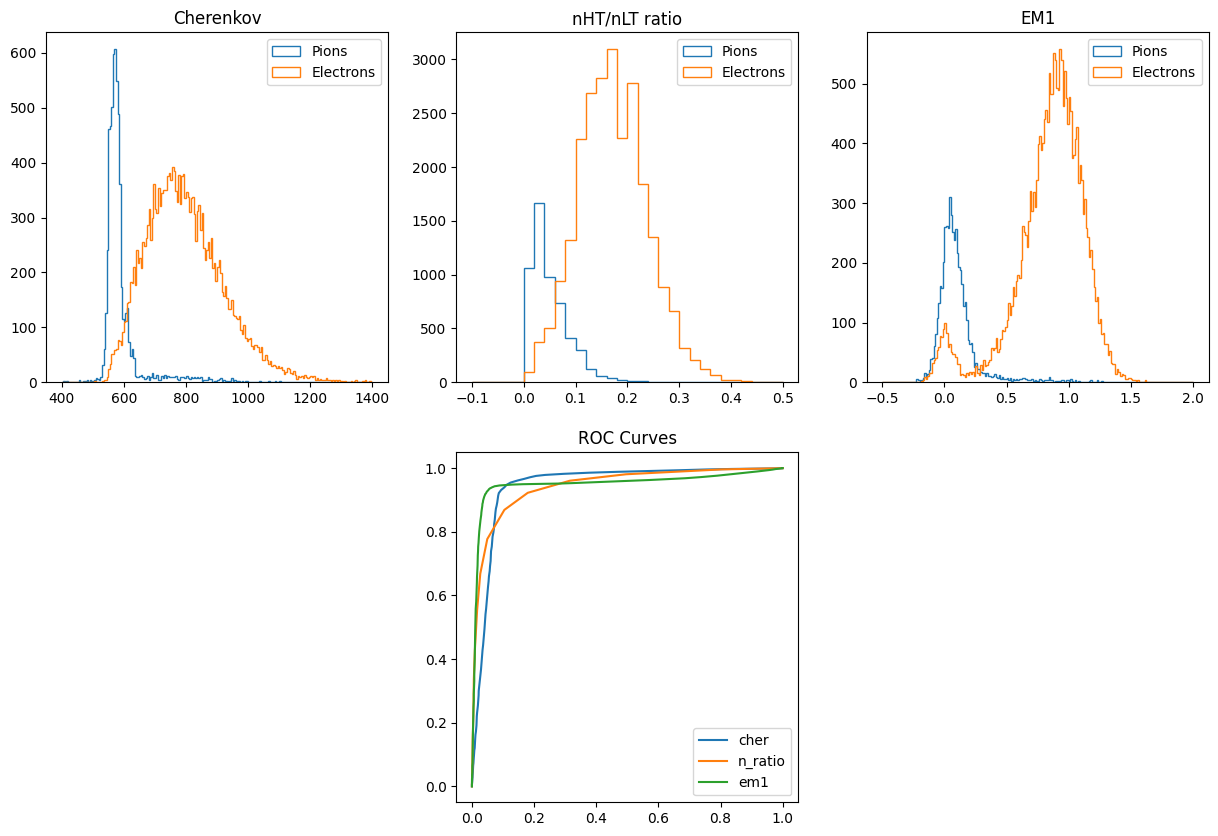

In [72]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))

em_n_mask_p = (trt_ratio < 0.1) & (EM1 < 0.5)
em_n_mask_e = (trt_ratio > 0.1) & (EM1 > 0.3)

pions_cher = ax[0,0].hist(Cher[em_n_mask_p],  bins=200, range=(400, 1400), histtype='step', label='Pions')
electrons_cher = ax[0,0].hist(Cher[em_n_mask_e],  bins=200, range=(400, 1400), histtype='step', label='Electrons')
ax[0,0].legend()
ax[0,0].set_title("Cherenkov")

em_cher_mask_p = (Cher < 600) & (EM1 < 0.5)
em_cher_mask_e = (Cher > 600) & (EM1 > 0.3)
pions_n = ax[0,1].hist(trt_ratio[em_cher_mask_p], bins = 30, range = (-0.1, 0.5), histtype = "step", label = "Pions")
electrons_n = ax[0,1].hist(trt_ratio[em_cher_mask_e], bins = 30, range = (-0.1, 0.5), histtype = "step", label = "Electrons")
ax[0,1].legend()
ax[0,1].set_title("nHT/nLT ratio")

cher_n_mask_p = (Cher < 600) & (trt_ratio < 0.1)
cher_n_mask_e = (Cher > 600) & (trt_ratio > 0.1)
pions_em = ax[0,2].hist(EM1[cher_n_mask_p],  bins=200, range=(-0.5, 2.0), histtype='step', label='Pions')
electrons_em = ax[0,2].hist(EM1[cher_n_mask_e],  bins=200, range=(-0.5, 2.0), histtype='step', label='Electrons')
ax[0,2].legend()
ax[0,2].set_title("EM1")

labels = ["cher", "n_ratio", "em1"]
i = 0
for p, e in zip([pions_cher, pions_n, pions_em], [electrons_cher, electrons_n, electrons_em]):
    fpr, tpr = calc_ROC(p, e)
    ax[1,1].plot(tpr, fpr, label = labels[i])
    i += 1
ax[1,1].legend()
ax[1,1].set_title("ROC Curves")

fig.delaxes(ax[1,0])
fig.delaxes(ax[1,2])

NOTE: The simple plotting function gives a warning for EM1 (not Cher). Ask yourself, if you did a check of the original data file input values in any way? That is always "healthy"!
***

## Questions to be answered:

Generally, this analysis is about separating electrons and pions (and determining how well this can be done), followed by a few questions characterizing the detector response to each type of particle. Thus, you should imagine, that your new detector/equipment/questionaire gave you this output, and now it is up to you to find out, what this tells you about your experiment, and how to extract information from it in the best possible way. Typically, it will have taken you months (if not years) to get to this point.

Note that this data is NOT meant for “fine tuned analysis”, but rather “crude inspection”. You should try to get simple approximate answers out - I’m sure that you will afterwards be able to fine tune them.

Below are questions guiding you, some/most of which your analysis should cover, but you do **not** have to follow them blindly (I've put "Optional" on those that are not essential). Start by considering the data, and get a feel for the typical range of each variable. Plot the variables, both in 1D and also 2D! From considering these plots, guess/estimate an approximate knowledge of how electrons and pions distribute themselves in the variables above, and how to make a selection of these.

As described on the webpage introducing the data, there are three (relevant) detectors:
- Cherenkov (1 value),
- TRT (Transition Radiation Tracker, 2 values) and
- Calorimeters (4 values)

They are each capable of separating electrons and pions. As they are (largely) _INDEPENDENT_ (three separate detectors), they may be used to cross check each other, and this is what you should use, in fact the essential part of this (and many other) analysis!


Questions:
----------
1. Find for each of these three detector systems one variable, which seem to separate electrons and pions best. For example, start with the Cherenkov, which is only a single number, and assume/guess that the large peak at low values is mainly from pions, while the upper broad peak is from electrons (this you would know, as you designed the experiment). Now plot the TRT and Calorimeter distributions when the Cherenkov selects a pion and afterwards an electron. This should give you a good idea about how to separate pions and electrons using the TRT and Calorimeters.

    Hint: Sometimes variables from a single detector are more powerful, when they are combined, e.g. taken ratios of (or used in a Fisher or ML algorithm). For the TRT this may be somewhat doable, but for the EMcalo, it is not as simple. Here, one variable caries most of the separation power, but involving other layers may enhance the separation power. However, to begin with, just consider a single number from each detector.


2. Next you should try to see, if you can make a selection, which gives you a fairly large and clean electron and pion sample, respectively. The question is, how can you know how clean your sample is and how efficient your selection is?  This can actually be measured in the data itself, using the fact that there are three independent detectors. For example, start by making an electron and a pion selection using two of the three variables, and plot the third variable for each of these selections. Now you can directly see, how electrons and pions will distribute themselves in this third variable. Are you worried, that there are pions in your electron sample, and vice versa? Well, there will probably be, but so few, that it won't matter too much, at least not to begin with. Why? Well, let us assume that for each detector, 80% of electrons pass your requirement, but also 10% of pions do. Assuming an even number of electrons and pions (which is not really the case), then with two detector cuts, you should get a sample, which is: $\frac{0.8\cdot0.8} {0.8\cdot0.8 + 0.1\cdot0.1} = 98.5\%$ pure.

    Now with this sample based on cuts on the two other detectors, ask what fraction of electrons and pions passes your electron selection in the remaining detector. The fraction of electrons, that are not selected as electrons will be your TYPE I errors (False Negative Rate), denoted alpha, while the fraction of pions, that do pass the cut will be your TYPE II errors (False Positive Rate), denoted beta. Measure these for each of the two cuts in the three detector types, and ask yourself if they are "reasonable", i.e. something like in the example above. If not, then you should perhaps reconsider adjusting your cuts.

By now, you should for each detector have 6 numbers (first considering electrons and then pions as "Positive"):
    - The electron cut value above which you accept an electron.
    - The efficiency (i.e. True Positive Rate) for electrons of this cut.
    - The fake rate (i.e. False Positive Rate) for pions of this cut.
    - The pion cut value below which you accept a pion (may be same value as above for electrons!).
    - The efficiency (i.e. True Positive Rate) for pions of this cut.
    - The fake rate (i.e. False Positive Rate) for electrons of this cut.


3. Given the efficiencies and fake rates of each cut, try to combine these (again assuming that they are independent) into knowledge of your sample purities and also the total number of electrons and pions in the whole sample. Do the sum of estimated electrons and pions added actually match the number of particles in total? This is a good cross check!

### More advanced questions:

4. If the number of pions was suddenly 1000 times that of elections, would you still be able to get a sample of fairly pure (say 90% pure) electrons? And if so, what would the efficiency for these electrons be? That is roughly equivalent of asking, if you can get a 99.9% pure electron sample from the data given (where pions do not dominate in numbers).


5. Expanding on problem 2), try now to calculate ROC curves for each of the three detectors. These are obtained by making a clean selection using the two other detectors for electrons and pions seperately, and then integrating over these two distributions, using the running (normalised) integral of each as x and y coordinate in a (ROC) curve. If you do not manage on your own, perhaps consider the ROC calculator example, which is posted along with this exercise.


6. One of the purposes of the testbeam was to measure the response of the TRT detector to exactly electrons and pions. Consider for example only events that has 33 TRT hits (i.e. `nLT` $= 33$). As the High-Threshold probability (i.e. probability of passing the High-Threshold, given that the Low-Threshold was passed), is assumed to be constant in the TRT detector (but quite different for electrons and pions), what distribution should the number of High-Threshold hits (`nHT`) follow? And is that really the case, both for electrons and pions?


7. Still considering `nLT` $=33$, and given that there are both electrons and pions in the sample (each with a different HT probability), `nHT` should in the unselected data be a combination of two distributions. Try to fit the number of HT hits with two distributions combined. Do they fit the data? And can this fit be used to estimate the fraction of pions and electrons in the sample? And does that estimate match you previous estimate? Perhaps retry with other values for the number of TRT hits.


8. Try to select pions using three different (mutually exclusive) techniques:
    1. Passing only a hadronic calorimeter requirement (e.g. that the sum of the three HCal values is above some minimum energy).
    2. Passing only Cherenkov AND EMcalo requirements.
    3. Passing both A) and B).

Try to measure the HT probability (i.e. fraction of High-Threshold hits) for each of these three pion samples. Do they agree with each other?

# Learning points:

This exercise might be the closest thing to reality regarding real data that is not easily modelled. Note that the original raw data is a lot more messy, and that a lot of cleaning has taken place, before you got it!

From this exercise you should realise:
1. that real data is not as clean-cut, well-behaved, and Gaussian as you might think.
2. that the use of **independent variables is very powerful** in data analysis.
3. that you need to be sharp regarding TPR, FPR, TNR, and FNR... :-)
4. that the sign of a good analysis is, that cross checks have been thought into it (e.g. end of Q.3)